#### Import Library

In [40]:
import os, glob
os.makedirs("artifacts", exist_ok=True)

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import silhouette_score, classification_report
from sklearn.neighbors import BallTree
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from joblib import dump, load

# Klasik ML
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#  Neural Network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

#### Load Data

In [2]:
df = pd.read_csv("data.csv")
df.head()

,long,lat,id_restaurant,id_reting,id_makanan,id_provinsi,id_kabupaten,nama_tempat,alamat
0,106.149564,-6.143376,1,1,1,36,3673,Sate Bandeng Ibu Amenah Serang,"Jl. Sayabulu km 1, Lingk No.11, RT.2/RW.1, Dal..."
1,106.150161,-6.120695,2,2,1,36,3673,Sate Bandeng - Bekakak Ayam Hj. Mariyam,"Tengah, Jl. Ki Uju No.63, RT.003/RW.002, Tenga..."
2,106.157729,-6.106640,3,3,1,36,3673,Sate Bandeng Ibu Aliyah,"Jl. Lopang Gede III, Lopang, Kec. Serang, Kota..."
3,106.152353,-6.112720,4,4,2,36,3673,Rabeg Khas Serang H. Naswi (Magersari),"Jl. Mayor Safei No.30, Kotabaru, Kec. Serang, ..."
4,106.170051,-6.105310,5,5,2,36,3673,Warung Dahar Rabeg Khas Wong Banten,"Jalan Ayip Usman, Link. Cikepuh, Unyur, Kec. S..."


#### Preprocessing

In [3]:
# Drop baris dengan koordinat kosong/invalid
df = df.dropna(subset=['long','lat'])
# Filter koordinat yang sesuai standar
df = df[(df['long']>=-180)&(df['long']<=180)&(df['lat']>=-90)&(df['lat']<=90)]

#### Scaling Long dan Lat

In [ ]:
# Standarisasi lon/lat untuk KMeans pakai StandarScaler
scaler_geo = StandardScaler()
X_geo = scaler_geo.fit_transform(df[['long','lat']])

#### Pencarian K Terbaik untuk K-Means

In [5]:
# Coba beberapa K, pilih lewat silhouette
Ks = range(3, 15)  # ubah sesuai skala data
scores = []
for k in Ks:
    kmeans_tmp = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=2048, n_init=10)
    labels_tmp = kmeans_tmp.fit_predict(X_geo)
    score = silhouette_score(X_geo, labels_tmp)
    scores.append(score)

best_k = Ks[int(np.argmax(scores))]
print("Best K by silhouette:", best_k)

c:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
c:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
c:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
c:\U

Best K by silhouette: 6


### Model Training

#### Pembangunan Model K-Means Clustering

In [6]:
kmeans = MiniBatchKMeans(n_clusters=best_k, random_state=42, batch_size=2048, n_init=20)
df['cluster'] = kmeans.fit_predict(X_geo)

c:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


##### Ciri-ciri profil dari masing-masing cluster yang dihasilkan

In [7]:
def top_counts(s, topn=5):
    return s.value_counts().head(topn)

profile_rows = []
for c in sorted(df['cluster'].unique()):
    sub = df[df['cluster']==c]
    centroid_std = kmeans.cluster_centers_[c]
    # balik ke koordinat asli
    centroid = scaler_geo.inverse_transform(centroid_std.reshape(1,-1))[0]
    row = {
        "cluster": c,
        "n_points": len(sub),
        "centroid_lon": centroid[0],
        "centroid_lat": centroid[1],
        "top_province_id": ", ".join(map(str, top_counts(sub['id_provinsi']).index.tolist())),
        "top_district_id": ", ".join(map(str, top_counts(sub['id_kabupaten']).index.tolist())),
        "top_food_id": ", ".join(map(str, top_counts(sub['id_makanan']).index.tolist()))
    }
    profile_rows.append(row)

cluster_profile = pd.DataFrame(profile_rows).sort_values('n_points', ascending=False)
cluster_profile

,cluster,n_points,centroid_lon,centroid_lat,top_province_id,top_district_id,top_food_id
2,2,46,110.276934,-7.746102,"34, 33, 32","3471, 3402, 3372, 3306, 3310","20, 29, 28, 27, 26"
1,1,41,106.855193,-6.247222,"31, 32","3171, 3173, 3172, 3174, 3276","8, 7, 12, 9, 11"
5,5,39,106.143011,-6.098890,36,"3673, 3672, 3604, 3601","2, 1, 3, 4, 5"
0,0,33,112.532833,-7.523009,35,"3578, 3515, 3573, 3524, 3506","34, 38, 35, 36, 37"
3,3,29,107.699701,-6.922746,"32, 33","3273, 3217, 3279, 3203, 3206","12, 13, 14, 15, 17"
4,4,20,110.739821,-6.970302,"33, 35","3374, 3318, 3523, 3524, 3373","24, 25, 21, 20, 41"


#### Pembangunan Model Klasifikasi RF NB KNN

In [ ]:
# Pastikan kolom wajib ada
required = ["long","lat","id_provinsi","id_kabupaten","id_makanan","id_reting"]
for c in required:
    if c not in df.columns:
        raise ValueError(f"Kolom '{c}' tidak ditemukan. Tolong rename kolom agar sesuai.")

# Cluster harus ada (hasil KMeans). Jika belum, siapkan dulu label cluster di df['cluster'].
if "cluster" not in df.columns:
    raise ValueError("Kolom 'cluster' belum ada. Jalankan KMeans dulu dan simpan labelnya ke df['cluster'].")

klasik_ml_df = df.copy()

# Ngecek aja mastiin tidak ada nilai kosong
klasik_ml_df.isnull().sum()

long             0
lat              0
id_restaurant    0
id_reting        0
id_makanan       0
id_provinsi      0
id_kabupaten     0
nama_tempat      0
alamat           0
cluster          0
dtype: int64

##### Penentuan Fitur dan Target

In [11]:
SEED = 42

num_cols = ["long", "lat"]
cat_cols = ["id_provinsi", "id_kabupaten", "id_makanan", "id_reting"]

X = klasik_ml_df[num_cols + cat_cols].copy()

for c in cat_cols:
    X[c] = X[c].astype(str).fillna("UNK")

y = klasik_ml_df["cluster"].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

##### Melakukan One Hot Encoding (ohe) dan Scaling StandarScaler dengan Pipeline ColumnTransformer

In [12]:
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
pre_dense = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=True), num_cols),
        ("cat", ohe, cat_cols),
    ],
    remainder="drop",
    sparse_threshold=0.0,   # paksa dense
)

##### Pembangunan Model

In [13]:
models = {
    "random_forest": Pipeline([
        ("pre", pre_dense),
        ("clf", RandomForestClassifier(
            n_estimators=400, n_jobs=-1, random_state=SEED,
            class_weight="balanced_subsample"
        ))
    ]),
    "knn": Pipeline([
        ("pre", pre_dense),
        ("clf", KNeighborsClassifier(n_neighbors=15))
    ]),
    "gaussian_nb": Pipeline([
        ("pre", pre_dense),
        ("clf", GaussianNB())
    ]),
}

#### Evaluasi dengan Cross Validation dan Classification Report

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
rows = []
best_name, best_f1 = None, -1.0

for name, pipe in models.items():
    print(f"\n=== {name} ===")
    cvres = cross_validate(pipe, X_train, y_train, cv=cv,
                           scoring=["accuracy","f1_macro"],
                           n_jobs=-1, return_train_score=False)
    acc_mean, acc_std = cvres["test_accuracy"].mean(), cvres["test_accuracy"].std()
    f1_mean,  f1_std  = cvres["test_f1_macro"].mean(), cvres["test_f1_macro"].std()
    print(f"CV Acc: {acc_mean:.4f} ± {acc_std:.4f} | CV F1-macro: {f1_mean:.4f} ± {f1_std:.4f}")

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average="macro")
    print(f"TEST Acc: {acc:.4f} | TEST F1-macro: {f1:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))

    outpath = f"artifacts/model_{name}.joblib"
    dump(pipe, outpath)
    print(f"Saved: {outpath}")

    rows.append({
        "model": name,
        "cv_acc_mean": acc_mean, "cv_acc_std": acc_std,
        "cv_f1_mean": f1_mean, "cv_f1_std": f1_std,
        "test_acc": acc, "test_f1_macro": f1
    })
    if f1 > best_f1:
        best_f1, best_name = f1, name


=== random_forest ===
CV Acc: 0.9638 ± 0.0122 | CV F1-macro: 0.9543 ± 0.0106
TEST Acc: 1.0000 | TEST F1-macro: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         8

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42

Saved: artifacts/model_random_forest.joblib

=== knn ===
CV Acc: 0.9337 ± 0.0228 | CV F1-macro: 0.9208 ± 0.0240
TEST Acc: 0.9762 | TEST F1-macro: 0.9761
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      0.88      0.93         8
           2       1.0

##### Buat Summary Perbandingannya

In [15]:
summary = pd.DataFrame(rows).sort_values("test_f1_macro", ascending=False)
summary.to_csv("artifacts/classic_ml_results.csv", index=False)
print("\n== Ringkasan → artifacts/classic_ml_results.csv ==")
summary


== Ringkasan → artifacts/classic_ml_results.csv ==


,model,cv_acc_mean,cv_acc_std,cv_f1_mean,cv_f1_std,test_acc,test_f1_macro
0,random_forest,0.963815,0.012215,0.954256,0.010608,1.000000,1.000000
1,knn,0.933690,0.022783,0.920792,0.024044,0.976190,0.976068
2,gaussian_nb,0.909626,0.057506,0.899942,0.058916,0.928571,0.921902


##### Bikin Confusion Matrix dari Model Klasik ML yang terbaik

Saved confusion matrix: artifacts/confusion_best.png


<Figure size 600x500 with 0 Axes>

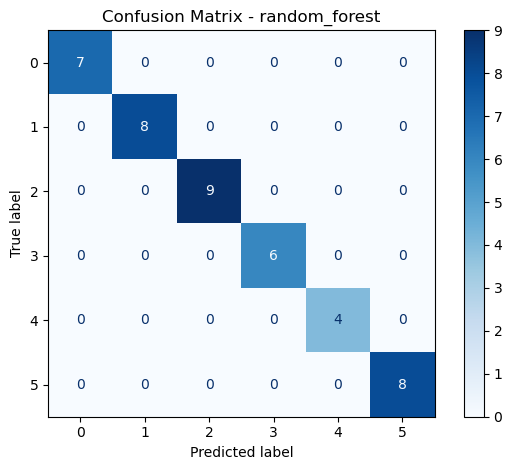

In [16]:
# Confusion matrix untuk model terbaik
from sklearn.metrics import ConfusionMatrixDisplay
plt.figure(figsize=(6,5))
best_pipe = models[best_name].fit(X_train, y_train)
y_pred_best = best_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
ConfusionMatrixDisplay(cm).plot(values_format='d', cmap='Blues')
plt.title(f"Confusion Matrix - {best_name}")
plt.tight_layout(); plt.savefig("artifacts/confusion_best.png", dpi=160)
print("Saved confusion matrix: artifacts/confusion_best.png")

#### Pembangunan Model Klasifikasi Neural Network

#### Penentuan Fitur dan Target

In [24]:
nn_klasifikasi_df = df.copy()

target = nn_klasifikasi_df['cluster'].astype(int)

feature_cols_num = ['long','lat']
feature_cols_cat = ['id_provinsi','id_kabupaten','id_makanan','id_reting']  # sesuaikan yang relevan

X_num = nn_klasifikasi_df[feature_cols_num]
X_cat = nn_klasifikasi_df[feature_cols_cat].astype(str)  # pastikan string utk encoder

##### Pembuatan Column Transformer Pipeline

In [25]:
# ColumnTransformer: scale numerik + one-hot kategorikal
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_cols_num),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), feature_cols_cat)
    ]
)

X_all = preprocess.fit_transform(pd.concat([X_num, X_cat], axis=1))
y_all = target.values

##### Splitting Data

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all)

# Karena X_all kemungkinan sparse, konversi ke dense hanya jika ukuran masih aman.
# Kalau sangat besar, lebih baik pakai model non‑NN (mis. LightGBM). Untuk contoh, kita dense-kan:
if hasattr(X_train, "toarray"):
    X_train = X_train.toarray()
    X_test  = X_test.toarray()

num_classes = len(np.unique(y_all))

In [27]:
X_all

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1248 stored elements and shape (208, 305)>

In [28]:
y_all

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
       3, 3, 3, 3, 2, 1, 2, 2, 4, 2, 2, 2, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2,
       4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0,
       4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 4, 2, 3, 2, 2, 2, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 3, 3, 1, 1,
       3, 3, 1, 3, 3, 1, 3, 3, 3, 3])

In [29]:
X_train

array([[-0.54383635,  0.02080427,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.54510551,  0.01230293,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.63725365, -1.31892937,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.55205264,  0.03166992,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.66155895, -0.09574825,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.66152421, -0.0987793 ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [30]:
X_test

array([[ 1.62725235, -0.74333464,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.66378845, -0.10363678,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.54012924, -0.0073772 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.82422008, -1.24102842,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.52704949,  0.02129721,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.15859058,  1.14856036,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [31]:
y_train

array([3, 3, 2, 0, 1, 4, 4, 3, 3, 2, 1, 3, 1, 4, 4, 2, 3, 0, 2, 2, 5, 0,
       2, 0, 5, 3, 3, 5, 5, 5, 1, 2, 5, 4, 1, 2, 3, 1, 0, 1, 4, 5, 3, 2,
       0, 3, 0, 2, 1, 1, 2, 2, 4, 1, 1, 1, 5, 5, 1, 1, 2, 2, 1, 1, 0, 1,
       2, 2, 0, 2, 3, 0, 5, 3, 0, 0, 2, 5, 4, 1, 2, 5, 1, 5, 2, 5, 0, 0,
       4, 2, 5, 1, 2, 2, 5, 1, 5, 5, 0, 5, 2, 3, 0, 3, 0, 1, 1, 5, 0, 1,
       0, 5, 5, 2, 3, 5, 0, 0, 3, 1, 2, 1, 0, 1, 2, 1, 2, 0, 5, 3, 2, 1,
       4, 1, 2, 2, 0, 2, 2, 4, 3, 5, 3, 3, 2, 0, 1, 5, 4, 2, 1, 5, 4, 5,
       4, 2, 1, 5, 0, 5, 2, 5, 3, 3, 4, 4])

In [32]:
y_test

array([0, 4, 3, 2, 1, 4, 0, 5, 5, 5, 4, 5, 0, 4, 1, 2, 3, 0, 1, 5, 2, 5,
       3, 2, 3, 3, 0, 1, 2, 2, 1, 1, 2, 1, 0, 2, 5, 0, 1, 2, 3, 5])

#### Pembangunan Model NN

In [33]:
# Bangun NN sederhana
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

es = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    callbacks=[es],
    verbose=1
)

# Evaluasi
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred))

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1136 - loss: 1.8097 - val_accuracy: 0.1176 - val_loss: 1.7880
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2500 - loss: 1.7421 - val_accuracy: 0.3235 - val_loss: 1.7426
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3561 - loss: 1.7019 - val_accuracy: 0.4412 - val_loss: 1.6988
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6212 - loss: 1.6211 - val_accuracy: 0.5588 - val_loss: 1.6555
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6515 - loss: 1.5910 - val_accuracy: 0.6176 - val_loss: 1.6126
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6894 - loss: 1.5016 - val_accuracy: 0.6176 - val_loss: 1.5688
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7424 - loss: 1.4445 - val_accuracy: 0.6176 - val_loss: 1.5251
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7652 - loss: 1.4036 - val_accuracy: 0.6176 - val_loss: 1.4810
Ep

#### Penyimpanan Kebutuhan untuk Deployment (Scaler, KMeans, Preprocess untuk Column Transformer, Model Neural Network, BallTree Haversine untuk melihat lokasi terdekat restoran) 

In [34]:
# Simpan proses pipeline clustering
dump(scaler_geo, "scaler_geo.joblib")
dump(kmeans, "kmeans.joblib")

# Simpan column transformer klasifikasi
dump(preprocess, "preprocess.joblib")
model.save("nn_cluster_classifier.keras")

# Buat struktur untuk nearest restaurant:
# BallTree dengan metrik haversine (pakai radian)
def deg2rad(df):
    return np.deg2rad(df[['lat','long']].values)

coords_rad = deg2rad(df)
tree = BallTree(coords_rad, metric='haversine')
# Simpan data pendukung untuk lookup hasil neighbor
dump(tree, "balltree_haversine.joblib")
df[['id_restaurant','nama_tempat','alamat','lat','long','cluster']].to_csv("restaurants_ref.csv", index=False)


In [35]:
# -------- fungsi plot kurva (punyamu, tetap) --------
def plot_training_curves(history, out_acc="artifacts/acc_curve.png", out_loss="artifacts/loss_curve.png"):
    os.makedirs(os.path.dirname(out_acc), exist_ok=True)
    H = history.history
    acc_key = "accuracy" if "accuracy" in H else "acc"
    val_acc_key = "val_accuracy" if "val_accuracy" in H else "val_acc"
    loss_key, val_loss_key = "loss", "val_loss"
    epochs = range(1, len(H[loss_key]) + 1)

    # Accuracy
    plt.figure()
    plt.plot(epochs, H[acc_key], label="Train Acc")
    plt.plot(epochs, H[val_acc_key], label="Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Training vs Validation Accuracy"); plt.legend()
    plt.tight_layout(); plt.savefig(out_acc, dpi=160); plt.close()

    # Loss
    plt.figure()
    plt.plot(epochs, H[loss_key], label="Train Loss")
    plt.plot(epochs, H[val_loss_key], label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training vs Validation Loss"); plt.legend()
    plt.tight_layout(); plt.savefig(out_loss, dpi=160); plt.close()


# -------- fungsi plot confusion matrix + report --------
def plot_confusion_and_report(model, X_test, y_test,
                              class_names=None,
                              out_png="artifacts/confusion_raw.png",
                              out_norm_png="artifacts/confusion_norm.png",
                              out_report="artifacts/classification_report.txt"):
    os.makedirs(os.path.dirname(out_png), exist_ok=True)

    # y_true: tangani one-hot vs integer
    y_true = y_test
    if hasattr(y_true, "values"):  # pandas Series/DF
        y_true = y_true.values
    y_true = np.asarray(y_true)
    if y_true.ndim > 1:
        y_true = np.argmax(y_true, axis=1)

    # y_pred: dukung Keras (prob/logit) & sklearn (label)
    y_pred = model.predict(X_test)
    if hasattr(y_pred, "values"):
        y_pred = y_pred.values
    y_pred = np.asarray(y_pred)

    if y_pred.ndim > 1:
        # multi-class prob/logit -> ambil argmax
        y_pred = np.argmax(y_pred, axis=1)
    else:
        # binary shape (n,) sudah ok; shape (n,1) -> ravel
        y_pred = y_pred.ravel()

    # tentukan jumlah kelas & label tampilan
    n_classes = int(max(np.max(y_true), np.max(y_pred))) + 1
    if class_names is None:
        class_names = [f"c{i}" for i in range(n_classes)]

    # Confusion matrix (raw counts)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(n_classes)))
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    plt.figure(figsize=(6,5))
    disp.plot(values_format='d', cmap='Blues', colorbar=False)
    plt.title("Confusion Matrix (Raw)")
    plt.tight_layout(); plt.savefig(out_png, dpi=160); plt.close()

    # Confusion matrix (normalized per true class)
    cm_norm = confusion_matrix(y_true, y_pred, labels=list(range(n_classes)), normalize='true')
    disp2 = ConfusionMatrixDisplay(cm_norm, display_labels=class_names)
    plt.figure(figsize=(6,5))
    disp2.plot(values_format='.2f', cmap='Blues', colorbar=True)
    plt.title("Confusion Matrix (Normalized by True Labels)")
    plt.tight_layout(); plt.savefig(out_norm_png, dpi=160); plt.close()

    # Classification report -> txt
    report_txt = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
    with open(out_report, "w", encoding="utf-8") as f:
        f.write(report_txt)

    print(f"Saved:\n- {out_png}\n- {out_norm_png}\n- {out_report}")


In [36]:
plot_training_curves(history)
print("Saved curves to artifacts/acc_curve.png and artifacts/loss_curve.png")

# Untuk Keras NN
plot_confusion_and_report(model, X_test, y_test,
                          class_names=[f"c{i}" for i in range(num_classes)],
                          out_png="artifacts/confusion_raw.png",
                          out_norm_png="artifacts/confusion_norm.png",
                          out_report="artifacts/classification_report.txt")


Saved curves to artifacts/acc_curve.png and artifacts/loss_curve.png
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Saved:
- artifacts/confusion_raw.png
- artifacts/confusion_norm.png
- artifacts/classification_report.txt


<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

#### Tambahan doang untuk bikin Conf Matrix semuanya (RF, NB, KNN)

In [37]:
SEED = 42
ART_DIR = "HasilMLClassic"
os.makedirs(ART_DIR, exist_ok=True)

In [41]:
# siapkan fitur mentah (pipeline klasik sudah punya preprocessing sendiri)
X = klasik_ml_df[["long","lat","id_provinsi","id_kabupaten","id_makanan","id_reting"]].copy()
# kategorikal jadi string agar OneHot di pipeline aman
for c in ["id_provinsi","id_kabupaten","id_makanan","id_reting"]:
    X[c] = X[c].astype(str).fillna("UNK")

y = klasik_ml_df["cluster"].astype(int).values

# split (stratify)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# plot confusion & report
def plot_confusion_and_report(model, X_te, y_te, class_names=None, prefix="model"):
    y_true = np.asarray(y_te)
    # pred: dukung pipeline sklearn (output label) dan yang memulangkan prob
    y_pred = model.predict(X_te)
    y_pred = np.asarray(y_pred)
    if y_pred.ndim > 1:
        y_pred = np.argmax(y_pred, axis=1)

    n_classes = int(max(np.max(y_true), np.max(y_pred))) + 1
    if class_names is None:
        class_names = [f"c{i}" for i in range(n_classes)]

    # Confusion raw
    cm = confusion_matrix(y_true, y_pred, labels=list(range(n_classes)))
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    plt.figure(figsize=(6,5))
    disp.plot(values_format='d', cmap='Blues', colorbar=False)
    plt.title(f"Confusion Matrix (Raw) - {prefix}")
    plt.tight_layout()
    out_raw = os.path.join(ART_DIR, f"{prefix}_confusion_raw.png")
    plt.savefig(out_raw, dpi=160); plt.close()

    # Confusion normalized (per true class)
    cmn = confusion_matrix(y_true, y_pred, labels=list(range(n_classes)), normalize="true")
    disp2 = ConfusionMatrixDisplay(cmn, display_labels=class_names)
    plt.figure(figsize=(6,5))
    disp2.plot(values_format='.2f', cmap='Blues', colorbar=True)
    plt.title(f"Confusion Matrix (Normalized) - {prefix}")
    plt.tight_layout()
    out_norm = os.path.join(ART_DIR, f"{prefix}_confusion_norm.png")
    plt.savefig(out_norm, dpi=160); plt.close()

    # Classification report
    report_txt = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
    out_rep = os.path.join(ART_DIR, f"{prefix}_classification_report.txt")
    with open(out_rep, "w", encoding="utf-8") as f:
        f.write(report_txt)

    # Ringkas metrik
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")

    print(f"\n== {prefix} ==")
    print(f"Test Accuracy  : {acc:.4f}")
    print(f"Test F1-macro  : {f1m:.4f}")
    print(f"Saved:\n- {out_raw}\n- {out_norm}\n- {out_rep}")

    # Kembalikan metrik kalau mau disimpan agregat
    return {"model": prefix, "test_acc": acc, "test_f1_macro": f1m}

# Load semua model klasik & evaluasi 
paths = sorted(glob.glob(os.path.join(ART_DIR, "model_*.joblib")))
if not paths:
    raise FileNotFoundError("Tidak ada HasilMLClassic/model_*.joblib. Jalankan training klasik dulu.")

rows = []
for p in paths:
    clf = load(p)  # pipeline lengkap (preprocess + clf)
    name = os.path.basename(p).replace("model_","").replace(".joblib","")
    res = plot_confusion_and_report(clf, X_test_raw, y_test, class_names=None, prefix=name)
    rows.append(res)

# simpan ringkasan
pd.DataFrame(rows).sort_values("test_f1_macro", ascending=False).to_csv(
    os.path.join(ART_DIR, "classic_ml_eval_summary.csv"), index=False
)
print(f"\nRingkasan → {os.path.join(ART_DIR, 'classic_ml_eval_summary.csv')}")


== gaussian_nb ==
Test Accuracy  : 0.9286
Test F1-macro  : 0.9219
Saved:
- HasilMLClassic\gaussian_nb_confusion_raw.png
- HasilMLClassic\gaussian_nb_confusion_norm.png
- HasilMLClassic\gaussian_nb_classification_report.txt

== knn ==
Test Accuracy  : 0.9762
Test F1-macro  : 0.9761
Saved:
- HasilMLClassic\knn_confusion_raw.png
- HasilMLClassic\knn_confusion_norm.png
- HasilMLClassic\knn_classification_report.txt

== random_forest ==
Test Accuracy  : 1.0000
Test F1-macro  : 1.0000
Saved:
- HasilMLClassic\random_forest_confusion_raw.png
- HasilMLClassic\random_forest_confusion_norm.png
- HasilMLClassic\random_forest_classification_report.txt

Ringkasan → HasilMLClassic\classic_ml_eval_summary.csv


<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>